In [1]:
# importing necessary libraries
import torch, os

In [2]:
# installing transformers dataset
!pip install transformers dataset

In [3]:
# using the gpu
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# loading the movie dataset
from google.colab import files
texts = files.upload()

Saving Corpus.csv to Corpus (1).csv


In [5]:
# creating pandas dataframe
import pandas as pd
column_names = ["sentenceID", "text", "author", "year", "genre", "source"]
data = pd.read_csv('Corpus.csv', header=None, sep=';', names=column_names, encoding='utf-8', quoting=3)
data = data.sample(frac=1, random_state=42)
data.head()

,sentenceID,text,author,year,genre,source
8784,8-2395,"Am merkwürdigsten ist es, daß wir oft im Traum...",E.T.A. Hoffmann,1817,Prosa,Nachtstuecke
7699,8-1310,"Da sah er, wie er zwischen Strauchwerk in hohe...",E.T.A. Hoffmann,1817,Prosa,Nachtstuecke
4894,5-1412,Enguerrand de Marigny verteidigte sich in eine...,Heinrich Heine,1832,Prosa,Franzoesische Zustaende
7168,8-779,"Andres schien getröstet, im Innern beschloß er...",E.T.A. Hoffmann,1817,Prosa,Nachtstuecke
15616,12-691,"„Ich gewinne“, sagte er, „indem ich einen bequ...",J.W. von Goethe,1809,Lyrik,Die Wahlverwandtschaften


In [6]:
data["labels"] = data["author"].apply(lambda x: 1 if x == "Heinrich Heine" else 0)

In [7]:
id2label = {1: "Heinrich Heine", 0: "Nicht-Heine"}
label2id = {"Heinrich Heine": 1, "Nicht-Heine": 0}

In [8]:
data.head()

,sentenceID,text,author,year,genre,source,labels
8784,8-2395,"Am merkwürdigsten ist es, daß wir oft im Traum...",E.T.A. Hoffmann,1817,Prosa,Nachtstuecke,0
7699,8-1310,"Da sah er, wie er zwischen Strauchwerk in hohe...",E.T.A. Hoffmann,1817,Prosa,Nachtstuecke,0
4894,5-1412,Enguerrand de Marigny verteidigte sich in eine...,Heinrich Heine,1832,Prosa,Franzoesische Zustaende,1
7168,8-779,"Andres schien getröstet, im Innern beschloß er...",E.T.A. Hoffmann,1817,Prosa,Nachtstuecke,0
15616,12-691,"„Ich gewinne“, sagte er, „indem ich einen bequ...",J.W. von Goethe,1809,Lyrik,Die Wahlverwandtschaften,0


In [9]:
data.labels.value_counts()

0    13302
1     6389
Name: labels, dtype: int64

In [10]:
# importing BERT tokenizer and sequence classifier
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [11]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
data = data.dropna()

In [13]:
# split the data into train, val and test sets
SIZE = data.shape[0]

train_texts   = list(data.text[:SIZE//2])
val_texts     = list(data.text[SIZE//2:(3*SIZE)//4 ])
test_texts    = list(data.text[(3*SIZE)//4:])

train_labels  = list(data.labels[:SIZE//2])
val_labels    = list(data.labels[SIZE//2:(3*SIZE)//4])
test_labels   = list(data.labels[(3*SIZE)//4:])

In [14]:
len(train_texts), len(val_texts), len(test_texts)

(9845, 4923, 4923)

In [15]:
# Is the train data balanced?
data[:9845].labels.value_counts()

0    6632
1    3213
Name: labels, dtype: int64

<Axes: ylabel='labels'>

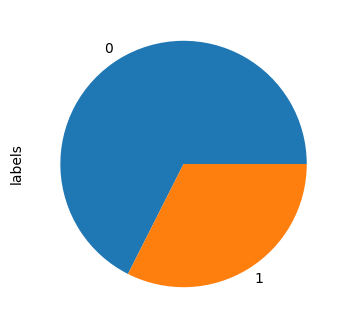

In [16]:
data.labels.value_counts().plot(kind="pie", figsize=(4,4))

In [17]:
data[:9845].author.value_counts()

E.T.A. Hoffmann    3827
Heinrich Heine     3213
J.W. von Goethe    2267
Theodor Storm       538
Name: author, dtype: int64

<Axes: ylabel='author'>

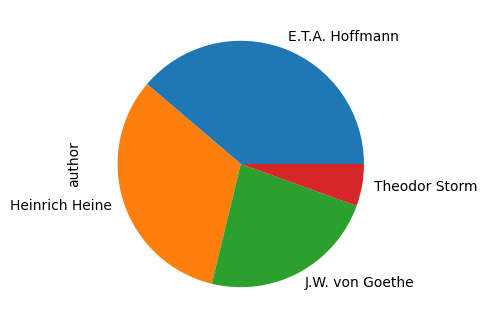

In [18]:
data.author.value_counts().plot(kind="pie", figsize=(4,4))

In [19]:
# encode the subtitle splits
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [20]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [21]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

In [22]:
# import trainer class
from transformers import TrainingArguments, Trainer

In [23]:
# define the metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [24]:
# install accelerators
!pip install transformers[torch]
!pip install accelerate -U
#!pip install --upgrade transformers
#!pip install git+https://github.com/huggingface/accelerate
#!pip install transformers[torch]
#!pip install accelerate -U

In [25]:
# setup of the trainer
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir= './HeinrichT',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

In [26]:
# Initializing the trainer class
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics= compute_metrics
)

In [27]:
# Train/fine-tune the BERT classifier
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.634000,0.701687,0.501117,0.500317,0.553053,0.556083
100,0.606600,0.603093,0.676214,0.403417,0.338107,0.500000
150,0.594400,0.560143,0.691042,0.455990,0.789818,0.524533
200,0.590200,0.587522,0.579931,0.579907,0.667268,0.665201
250,0.565100,0.512155,0.739590,0.640670,0.727074,0.633342
300,0.518500,0.491170,0.763559,0.745393,0.739437,0.764358
350,0.439700,0.458345,0.805606,0.769869,0.782449,0.761281
400,0.454500,0.395556,0.817794,0.771495,0.816139,0.752636
450,0.436200,0.377095,0.823482,0.780915,0.819775,0.762891
500,0.398900,0.350846,0.840951,0.809961,0.828887,0.797714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: ignored